## Factorización matricial no negativa (NMF)

La factorización de matricial no negativa es otro algoritmo de aprendizaje no supervisado que tiene como objetivo extraer características útiles. Funciona de manera similar a PCA y también se puede utilizar para la reducción de dimensionalidad. 

Al igual que en PCA, estamos tratando de escribir cada punto de datos como una suma ponderada de algunos componentes. Pero mientras que en PCA queríamos componentes que fueran ortogonales y que tengan tanta varianza de los datos como fuera posible, en NMF lo que se quiere es   que los componentes y los coeficientes sean no negativos; es decir, queremos que tanto los componentes como los coeficientes sean mayores o iguales a cero. 

El proceso de descomposición de datos en una suma ponderada no negativa es particularmente útil para los datos que se crean como la adición (o superposición) de varias fuentes independientes, como una pista de audio de varias personas hablando o música con muchos instrumentos. En estas situaciones, NMF puede identificar los componentes originales que componen los datos combinados.

En general, NMF conduce a componentes más interpretables que PCA, ya que los componentes y coeficientes negativos pueden llevar a efectos de cancelación difíciles de interpretar.

### Aplicando NFE

A diferencia de cuando se utiliza PCA, debemos asegurarnos de que nuestros datos sean positivos para que NMF pueda operar con los datos. Esto significa que los datos que se encuentran en relación con el origen `(0, 0)` realmente importan para el NMF. Por lo tanto, puede pensar en los componentes no negativos que se extraen como direcciones desde `(0, 0)` hacia los datos.

In [ ]:
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import numpy as np

from sklearn.externals.joblib import Memory

memory = Memory(cachedir="cache")


def dibuja_nmf():
    rnd = np.random.RandomState(5)
    X_ = rnd.normal(size=(300, 2))
    # Se agrea 8 para asegurarse de que cada punto se encuentre en la parte positiva del espacio
    X_s = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2) + 8

    nmf = NMF(random_state=0)
    nmf.fit(X_s)
    X_nmf = nmf.transform(X_s)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].scatter(X_s[:, 0], X_s[:, 1], c=X_nmf[:, 0], linewidths=0,
                    s=60, cmap='viridis')
    axes[0].set_xlabel("Caracteristica 1")
    axes[0].set_ylabel("Caracteristica 2")
    axes[0].set_xlim(0, 12)
    axes[0].set_ylim(0, 12)
    axes[0].arrow(0, 0, nmf.components_[0, 0], nmf.components_[0, 1], width=.1,
                  head_width=.3, color='k')
    axes[0].arrow(0, 0, nmf.components_[1, 0], nmf.components_[1, 1], width=.1,
                  head_width=.3, color='k')
    axes[0].set_aspect('equal')
    axes[0].set_title("NMF con dos componentes")

    # segundo grafico
    nmf = NMF(random_state=0, n_components=1)
    nmf.fit(X_s)

    axes[1].scatter(X_s[:, 0], X_s[:, 1], c=X_nmf[:, 0], linewidths=0,
                    s=60, cmap='viridis')
    axes[1].set_xlabel("caracteristica 1")
    axes[1].set_ylabel("caracteristica 2")
    axes[1].set_xlim(0, 12)
    axes[1].set_ylim(0, 12)
    axes[1].arrow(0, 0, nmf.components_[0, 0], nmf.components_[0, 1], width=.1,
                  head_width=.3, color='k')

    axes[1].set_aspect('equal')
    axes[1].set_title("NMF con una  componente")

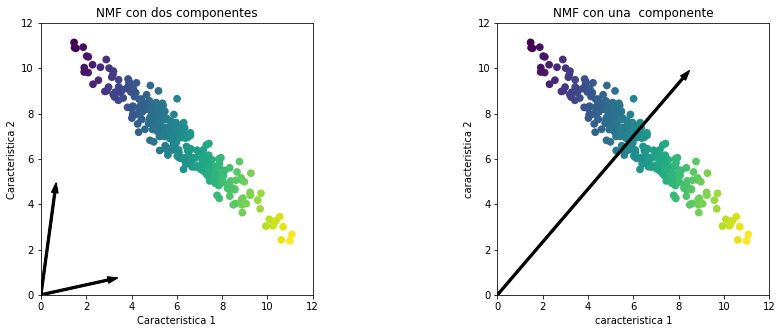

In [2]:
dibuja_nmf()

Para NMF con dos componentes, como se muestra a la izquierda, está claro que todos los puntos en los datos se pueden escribir como una combinación positiva de los dos componentes. Si hay suficientes componentes para reconstruir perfectamente los datos (tantos componentes como características), el algoritmo elegirá direcciones que apuntan hacia los extremos de los datos.

Si solo usamos un componente único, NMF crea un componente que apunta hacia la media, ya que al señalarlo se explican mejor los datos. A diferencia del  PCA, la reducción del número de componentes no solo elimina algunas direcciones, ¡sino que crea un conjunto de componentes completamente diferente! Los componentes en NMF tampoco se ordenan de ninguna manera específica, por lo que no existe un "primer componente no negativo": todos los componentes juegan en partes iguales.

NMF usa una inicialización aleatoria, que puede conducir a diferentes resultados dependiendo de la semilla aleatoria. En casos relativamente simples, como los datos artificiales con dos componentes, donde todos los datos se pueden explicar perfectamente, la aleatoriedad tiene poco efecto (aunque podría cambiar el orden o la escala de los componentes). En situaciones más complejas, podría haber cambios más drásticos.

Ahora, apliquemos NMF a Labeled Faces en el conjunto de datos Wild . El parámetro principal de NMF es cuántos componentes queremos extraer. Usualmente esto es más bajo que el número de características de entrada (de lo contrario, los datos podrían explicarse haciendo que cada píxel sea un componente separado).

Primero, inspeccionemos cómo la cantidad de componentes impacta en qué tan bien se pueden reconstruir los datos usando NMF:


In [3]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
%matplotlib inline

personas= fetch_lfw_people(min_faces_per_person=20, resize=0.7)
imagen_shape = personas.images[0].shape


In [4]:
mascara = np.zeros(personas.target.shape, dtype=np.bool)
for objetivo in np.unique(personas.target):
    mascara[np.where(personas.target == objetivo)[0][:50]] = 1

X_personas = personas.data[mascara]
y_personas = personas.target[mascara]

# la escala debe ir entre 0 y 1 en lugar de  0 y 255 
# para menor estabilidad numerica
X_personas = X_personas / 255.



X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X_personas,
                                        y_personas, stratify=y_personas, random_state=0)

In [5]:
@memory.cache
def nmf_caras(X_entrenamiento, X_prueba):
    imagenes_reducidas = []
    for n_componentes in [10, 50, 100, 500]:
        nmf = NMF(n_components=n_componentes, random_state=0)
        nmf.fit(X_entrenamiento)
        # transformaciones de pruebas
        X_prueba_nmf = nmf.transform(X_prueba)
        # volvemos  a transformar los datos de prueba transformados
        X_prueba_1 = np.dot(X_prueba_nmf, nmf.components_)
        imagenes_reducidas.append(X_prueba_1)
    return imagenes_reducidas


In [6]:
def dibuja_nmf_caras(X_entrenamiento, X_prueba, imagen_shape):
    imagenes_reducidas = nmf_caras(X_entrenamiento, X_prueba)

    # dibujamos  las primeras tres imágenes en el conjunto de prueba:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # dibujamos la imagen original
        ax[0].imshow(X_prueba[i].reshape(imagen_shape),
                     vmin=0, vmax=1)
        # dibujamos las cuatro imágenes transformadas 
        for a, X_prueba_1  in zip(ax[1:], imagenes_reducidas):
            a.imshow(X_prueba_1[i].reshape(imagen_shape), vmin=0, vmax=1)

    # etiqueta  la fila superior
    axes[0, 0].set_title("Imagen original")
    for ax, n_componentes in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("%d componentes" % n_componentes)

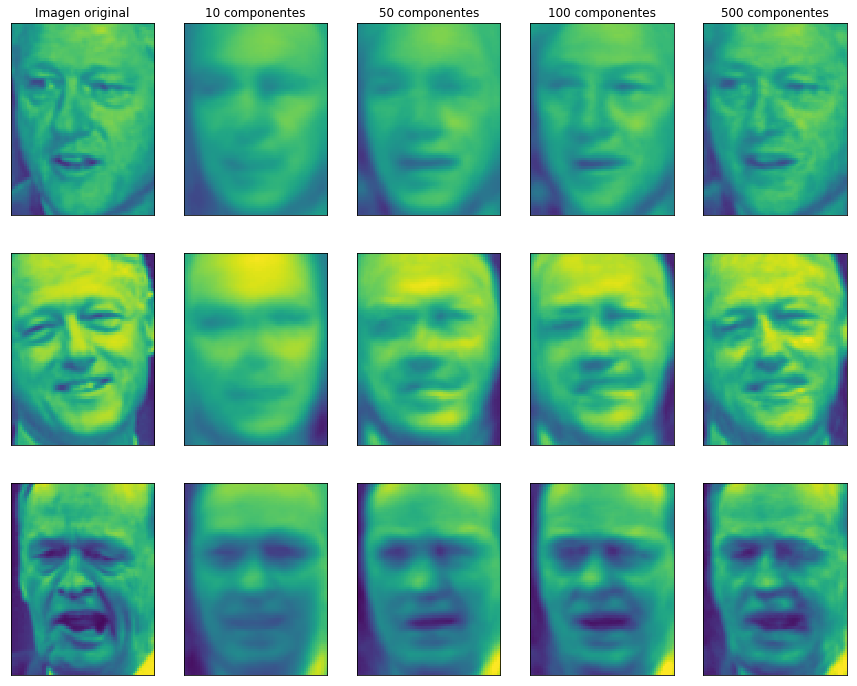

In [7]:
dibuja_nmf_caras(X_entrenamiento, X_prueba, imagen_shape)

La calidad de los datos transformados de regreso es similar a cuando se usa PCA, pero un poco peor. Esto es esperado, ya que PCA encuentra las direcciones óptimas en términos de reconstrucción. El NMF generalmente no se usa por su  capacidad de reconstruir o codificar datos, sino más bien para encontrar patrones interesantes dentro de los datos.


Como primer vistazo a los datos, intentemos extraer solo algunos componentes:

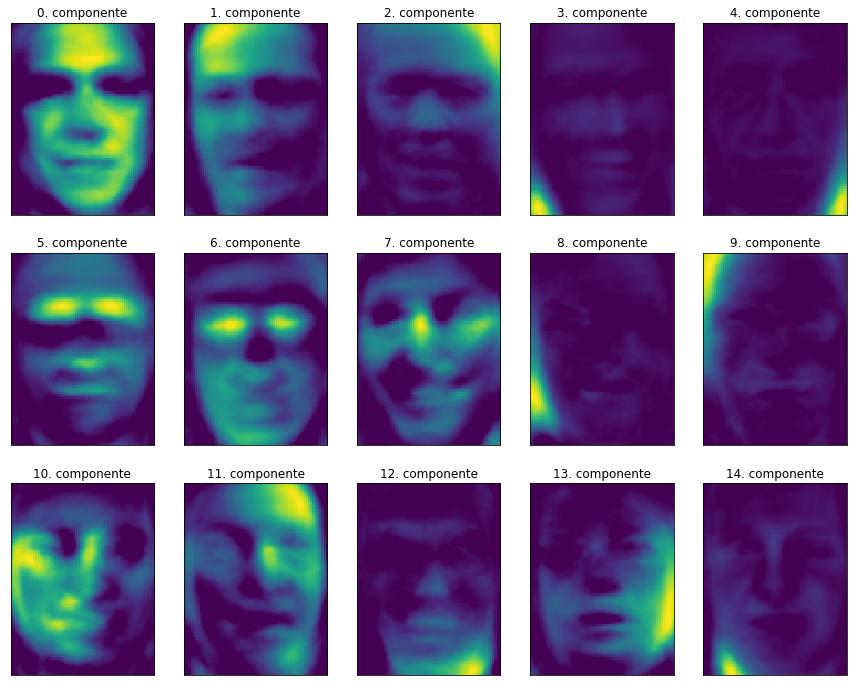

In [9]:
from sklearn.decomposition import NMF

# Los componentes encontrados por NMF en el conjunto de datos `Labeled Faces` cuando se usan 15 componentes
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_entrenamiento)
X_entrenamiento_nmf = nmf.transform(X_entrenamiento)
X_prueba_nmf = nmf.transform(X_prueba)
fix, axes = plt.subplots(3, 5, figsize=(15, 12),subplot_kw={'xticks': (), 'yticks': ()})
for i, (componente, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(componente.reshape(imagen_shape))
    ax.set_title("{}. componente".format(i))

Estos componentes son todos positivos  y se parecen mucho a prototipos de caras mucho más que los componentes mostrados para PCA. Por ejemplo, se puede ver claramente que el componente 3 muestra una cara girada un poco hacia la derecha, mientras que el componente 7 muestra una cara algo girada hacia la izquierda. Veamos las imágenes para las cuales estos componentes son particularmente fuertes, que se muestran en las siguientes figuras:

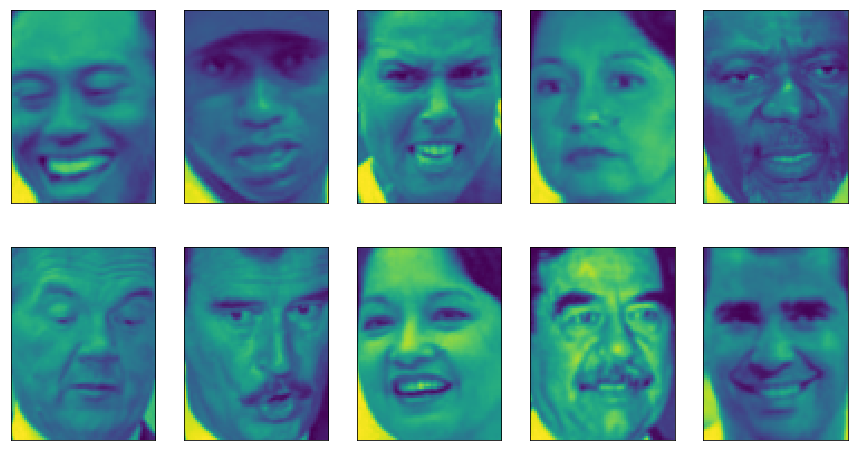

In [12]:
componente = 3
# ordenamos el 3 componente, diujamos las primeras 10 imágenes
inds = np.argsort(X_entrenamiento_nmf[:, componente])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_entrenamiento[ind].reshape(imagen_shape))

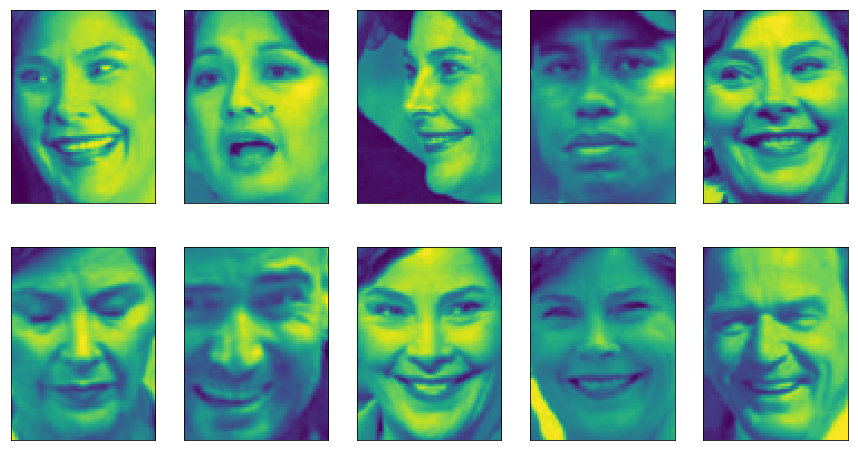

In [13]:
componente = 7
# ordenamos el 7 componente, diujamos las primeras 10 imágenes
inds = np.argsort(X_entrenamiento_nmf[:, componente])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_entrenamiento[ind].reshape(imagen_shape))

Como se esperaba, las caras que tienen un alto coeficiente para el componente 3 son caras que miran hacia la derecha, mientras que las caras con un alto coeficiente para el componente 7 miran hacia la izquierda. La extracción de patrones como estos funciona mejor para datos con estructura aditiva, incluyendo audio, expresión de genes y datos de texto. Veamos un ejemplo de datos artificiales  para ver cómo se vería esto.

In [14]:
from scipy import signal

def hacer_signals():
    rng = np.random.RandomState(42)
    n_muestras = 2000
    tiempo = np.linspace(0, 8, n_muestras)
    # creamos 3 signals
    s1 = np.sin(2 * tiempo) 
    s2 = np.sign(np.sin(3 * tiempo))  
    s3 = signal.sawtooth(2 * np.pi * tiempo)  

    # concatenamos los  signals, y agregamos ruido
    S = np.c_[s1, s2, s3]
    S += 0.2 * rng.normal(size=S.shape)

    S /= S.std(axis=0) 
    S -= S.min()
    return S

Text(0,0.5,'Signal')

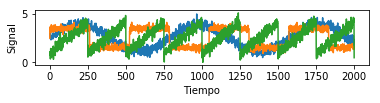

In [15]:
S = hacer_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("Tiempo")
plt.ylabel("Signal")

Desafortunadamente no podemos observar las señales originales, solo una mezcla aditiva de las tres.  Si suponemos que tenemos muchas maneras diferentes de observar la mezcla (digamos 100 dispositivos de medición), cada una de las cuales nos proporciona una serie de mediciones, encontremos  la descomposición de la señal mixta en los componentes originales. 

In [16]:
# mezclamos los  datos en un estado de 100 dimensiones
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("Dimension de las medidas: {}".format(X.shape))

Dimension de las medidas: (2000, 100)


Usamos NMF para recuperar las 3 señales:

In [17]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("Dimension de las senales recuperadas: {}".format(S_.shape))

Dimension de las senales recuperadas: (2000, 3)


In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)

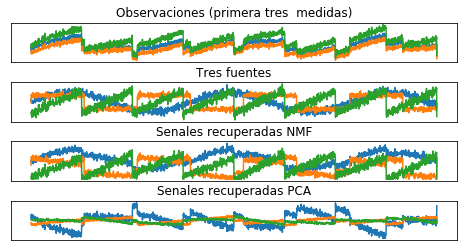

In [21]:
modelos = [X, S, S_, H]
nombres = ['Observaciones (primera tres  medidas)',
'Tres fuentes',
'Senales recuperadas NMF',
'Senales recuperadas PCA']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})
for modelo, nombre, ax in zip(modelos, nombres, axes):
    ax.set_title(nombre)
    ax.plot(modelo[:, :3], '-')

La figura incluye 3 de las 100 medidas de X para referencia. Del gráfico NMF hizo un trabajo razonable al descubrir las fuentes originales, mientras que PCA falló y utilizó el primer componente para explicar la mayoría de la variación en los datos. Se debe tener  en cuenta que los componentes producidos por NMF no tienen un orden natural. 

En este ejemplo, el orden de los componentes NMF es el mismo que en la señal original (ver el sombreado de las tres curvas), pero esto es puramente accidental.

Existen muchos otros algoritmos que se pueden usar para descomponer cada punto de datos en una suma ponderada de un conjunto fijo de componentes, como lo hacen PCA y NMF.  Si se está interesado en este tipo de extracción de patrones, se recomienda que se  estudie las secciones de la guía del usuario scikit_learn sobre el análisis de componentes independientes (ICA), el análisis de factores (FA) y la codificación escasa (aprendizaje de diccionarios), todo lo cual puede encuentre en la página sobre [métodos de descomposición](http://scikit-learn.org/stable/modules/decomposition.html).

## Manifold Learning con t-SNE

Si bien PCA es a menudo un buen primer acercamiento para transformar  datos  que se puedan visualizarlos usando un diagrama de dispersión, la naturaleza del método (aplicando una rotación y luego quitando direcciones) limita su utilidad. Existe una clase de algoritmos de visualización llamados `manifold learning algorithms` que permiten mapeos mucho más complejos y a  proporcionan mejores visualizaciones. Una particularmente útil es el algoritmo t-SNE.


Los algoritmos `manifold learning` se dirigen principalmente a la visualización, por lo que rara vez se utilizan para generar más de dos características nuevas. Algunos de ellos, incluido t-SNE, calculan una nueva representación de los datos de entrenamiento, pero no permiten transformaciones de datos nuevos. Esto significa que estos algoritmos no se pueden aplicar a un conjunto de prueba; más bien, solo pueden transformar los datos para los que fueron entrenados. El aprendizaje múltiple puede ser útil para el análisis exploratorio de datos, pero rara vez se utiliza si el objetivo final es el aprendizaje supervisado.

La idea detrás de t-SNE es encontrar una representación bidimensional de los datos que preserve las distancias entre los puntos de la mejor manera posible. t-SNE comienza con una representación bidimensional aleatoria para cada punto de datos y luego trata de acercar puntos que estén más cerca del espacio de característica original y puntos que estén muy separados en el espacio de  característica original. t-SNE pone más énfasis en los puntos que están cerca, en lugar de preservar las distancias entre los puntos más alejados.
En otras palabras, intenta preservar la información que indica qué puntos son vecinos entre sí.


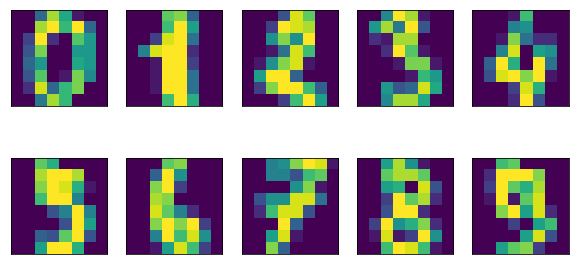

In [23]:
from sklearn.datasets import load_digits

digitos = load_digits()
fig, axes = plt.subplots(2, 5, figsize=(10, 5),
subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digitos.images):
    ax.imshow(img)

Usemos PCA para visualizar los datos reducidos a dos dimensiones. Dibujamos  los primeros dos componentes principales y coloreamos cada punto por su clase:

Text(0,0.5,'Segundo componente principal')

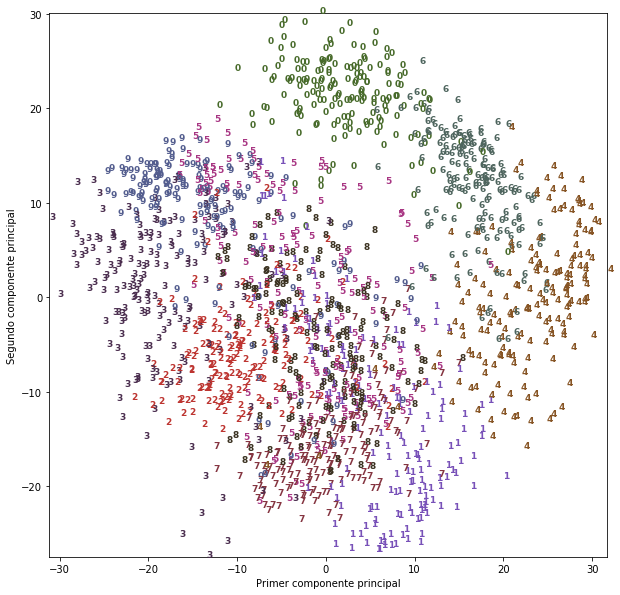

In [26]:
# Diagrama de dispersión del conjunto de datos de dígitos utilizando los dos primeros componentes principales

# Construimos un modelo PCA
pca = PCA(n_components=2)
pca.fit(digitos.data)

# transformamos la base de datos digitos en los dos primeros componentes
digitos_pca = pca.transform(digitos.data)
colores = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525", 
           "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digitos_pca[:, 0].min(), digitos_pca[:, 0].max())
plt.ylim(digitos_pca[:, 1].min(), digitos_pca[:, 1].max())

# dibujamos  los dígitos como texto en lugar de usar scatter
for i in range(len(digitos.data)):
    plt.text(digitos_pca[i, 0], digitos_pca[i, 1], str(digitos.target[i]),
             color = colores[digitos.target[i]],fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("Primer componente principal")
plt.ylabel("Segundo componente principal")

Aquí, usamos las clases de dígitos verdaderos como jeroglíficos, para mostrar de que clase son. Los dígitos cero, seis y cuatro están relativamente bien separados utilizando los dos primeros componentes principales, aunque todavía se superponen. La mayoría de los otros dígitos se superponen significativamente.

Vamos a aplicar t-SNE al mismo conjunto de datos y comparar los resultados. Como t-SNE no admite la transformación de nuevos datos, la clase TSNE no tiene ningún método `transform`. En cambio, podemos llamar al método `fit_transform`, que construirá el modelo e inmediatamente devolverá los datos transformados.



Text(0.5,0,' Caracteristica 1 t-SNE')

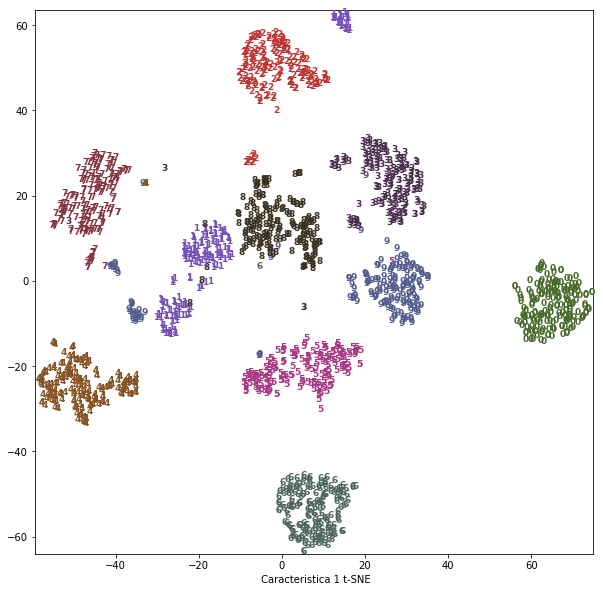

In [28]:
# Diagrama de dispersión del conjunto de datos de dígitos utilizando dos componentes encontrados por t-SNE

from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)

# usamos  fit_transform en lugar de fit, pues TSNE no tiene el metodo transform 
digitos_tsne = tsne.fit_transform(digitos.data)
plt.figure(figsize=(10, 10))
plt.xlim(digitos_tsne[:, 0].min(), digitos_tsne[:, 0].max() + 1)
plt.ylim(digitos_tsne[:, 1].min(), digitos_tsne[:, 1].max() + 1)

for i in range(len(digitos.data)):
    plt.text(digitos_tsne[i, 0], digitos_tsne[i, 1], str(digitos.target[i]),
                color = colores[digitos.target[i]], fontdict={'weight': 'bold', 'size': 9})
plt.xlabel(" Caracteristica 0 t-SNE")
plt.xlabel(" Caracteristica 1 t-SNE")

El resultado de t-SNE es bastante notable. Todas las clases están claramente separadas. Los uno y los nueve están algo divididos, pero la mayoría de las clases forman un solo grupo denso. Hay que tener en cuenta que este método no tiene conocimiento de las etiquetas de clase: no está supervisado por completo. Aún así, puede encontrar una representación de los datos en dos dimensiones que claramente separe las clases, basándose únicamente en qué tan cerca están los puntos en el espacio original.

El algoritmo t-SNE tiene algunos parámetros de ajuste, aunque a menudo funciona bien con la configuración predeterminada. Puedes intentar jugar con `perplexity` y `early_exaggeration`, pero los efectos son usualmente menores.